In [1]:
import os
import sys
sys.path.append("..")
from model.vit_vqgan.model import ViTVQGAN

/home/andrew264/miniconda3/envs/torch-cuda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
resolution = 256

In [3]:
model = ViTVQGAN(config={
        "hidden_size": 768,
        "image_size": resolution,
        "intermediate_size": 3072,
        "num_attention_heads": 12,
        "num_hidden_layers": 12,
        "patch_size": 16,
        "num_channels": 4,
        "attention_dropout": 0.0,
        "layer_norm_eps": 1e-6,
        "levels": [8, 8, 5, 5],
        "num_codebooks": 8,
    })

VQLPIPSWithDiscriminator running with hinge loss.


In [4]:
import torch


path = "/home/andrew264/PycharmProjects/ImageExperiments/weights/vitvqgan/weights-v1.ckpt"
sd = torch.load(path, weights_only=True)['state_dict']
model.load_state_dict(sd)
sd.keys()

odict_keys(['encoder.embeddings.patch_embedding.weight', 'encoder.embeddings.patch_embedding.bias', 'encoder.embeddings.position_embedding.weight', 'encoder.encoder.layers.0.self_attn.k_proj.weight', 'encoder.encoder.layers.0.self_attn.k_proj.bias', 'encoder.encoder.layers.0.self_attn.v_proj.weight', 'encoder.encoder.layers.0.self_attn.v_proj.bias', 'encoder.encoder.layers.0.self_attn.q_proj.weight', 'encoder.encoder.layers.0.self_attn.q_proj.bias', 'encoder.encoder.layers.0.self_attn.out_proj.weight', 'encoder.encoder.layers.0.self_attn.out_proj.bias', 'encoder.encoder.layers.0.layer_norm1.weight', 'encoder.encoder.layers.0.layer_norm1.bias', 'encoder.encoder.layers.0.mlp.fc1.weight', 'encoder.encoder.layers.0.mlp.fc1.bias', 'encoder.encoder.layers.0.mlp.fc2.weight', 'encoder.encoder.layers.0.mlp.fc2.bias', 'encoder.encoder.layers.0.layer_norm2.weight', 'encoder.encoder.layers.0.layer_norm2.bias', 'encoder.encoder.layers.1.self_attn.k_proj.weight', 'encoder.encoder.layers.1.self_attn.

In [5]:

import torchvision.transforms.v2 as transforms
from PIL import Image

to_tensor = transforms.PILToTensor()
to_dtype = transforms.ToDtype(torch.bfloat16, scale=True)
normalize = transforms.Normalize(mean=[0.5], std=[0.5])
resize = transforms.Resize((resolution, resolution), antialias=True)
def apply_transforms(img: Image.Image):
    image = resize(img.convert("RGBA"))
    tensor = to_tensor(image)
    tensor = to_dtype(tensor)
    tensor = normalize(tensor)
    return tensor

In [6]:
def undo_transforms(tensor: torch.Tensor) -> Image.Image:
    float_tensor = tensor.float()
    unnormalized_tensor = float_tensor * 0.5 + 0.5
    scaled_tensor = unnormalized_tensor * 255.0
    clamped_tensor = torch.clamp(scaled_tensor, 0, 255)
    uint8_tensor = clamped_tensor.to(torch.uint8)
    to_pil_transform = transforms.ToPILImage()
    pil_image = to_pil_transform(uint8_tensor)
    return pil_image

In [7]:
test_img = "/home/andrew264/PycharmProjects/ImageExperiments/data/test3.png"
from PIL import Image

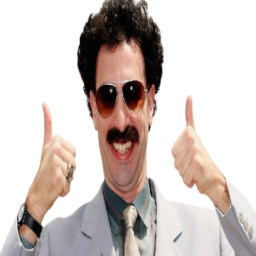

In [8]:
undo_transforms(apply_transforms(Image.open(test_img)))

In [9]:
with torch.no_grad():
    indices = model.encode(apply_transforms(Image.open(test_img)).unsqueeze(0))[-1]
indices, indices.shape

(tensor([[[1545,  199,  383,  ..., 1231, 1595,  698],
          [1545,  135,  383,  ..., 1231, 1596, 1083],
          [1537,  135,  383,  ..., 1231, 1275, 1082],
          ...,
          [ 368,   90, 1166,  ...,  674, 1542, 1101],
          [ 369,  222,  524,  ..., 1309, 1351,  770],
          [ 976, 1404,  401,  ...,  169,  842,  268]]], dtype=torch.int32),
 torch.Size([1, 256, 8]))

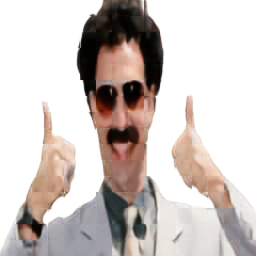

In [10]:
with torch.no_grad():
    out = model.decode(indices)[0]
undo_transforms(out)